
# Use a pretrained model to get more focal examples from the recordings we have on disk

The clips we've used so far for model training were taken from human labelled tags in wildtrax. Some of the tagging strategies are to only tag the first instance of an individual bird's vocalization within a given time period. This first vocalization might not necessarily be the loudest or the clearest, as there are possibly more un-tagged vocalizations in that time period. By using the model we have already trained, we can search the rest of the recordings for focal examples of the focal species calls. 

In [61]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram, SpectrogramPreprocessor
from opensoundscape.preprocess.utils import show_tensor
# import torch
from opensoundscape.data_selection import resample
from src.utils import get_hash_from_df, show_samples_in_df, show_sample_from_df, remove_short_clips, verify_samples
import matplotlib.pyplot as plt


# Load the labelled dataset from disk


In [2]:
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")

In [3]:
train_files = train_df.index.get_level_values("file").unique().values

# skip over this if the training set cheking has already begun

# Load the model to make predictions on the training dataframe

In [5]:
# Load the model saved at the end of the model training notebook
model = opso.cnn.load_model(model_save_path / "whole-aardvark-191.model")

In [49]:
all_results = model.predict(train_files, num_workers=4, batch_size=32, split_files_into_clips=True, overlap_fraction=0.5, final_clip="full", activation_layer="sigmoid")

  0%|          | 0/6149 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:346: UserWarning: Audio object is shorter than requested duration: 2.9379591836734695 sec instead of 3.0 sec.
  warnings.warn(error_msg)
[src/libmpg123/layer3.c:INT123_do_layer3():1773] error: part2_3_length (1408) too large for available bit count (1368)
[src/libmpg123/layer3.c:INT123_do_layer3():1773] error: part2_3_length (1408) too large for available bit count (1368)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:346: UserWarning: Audio object is shorter than requested duration: 2.967755102040816 sec instead of 3.0 sec.
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:346: UserWarning: Audio object is shorter than requested duration: 2.879591836734694 sec instead of 3.0 sec.
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:3

In [ ]:
all_results = remove_short_clips(all_results)

No short clips found in the dataframe.


Load predictions from here if already made.

In [7]:
all_results.to_pickle(data_path / "interim" / "train_set" / "preds_on_full_recordings_t.pkl")
# all_results = pd.read_pickle(data_path / "interim" / "train_set" / "preds_on_full_recordings_t.pkl")

In [52]:
top_focal = all_results.sort_values("target_present", ascending=False)[:3000]

These are the top scoring samples found by the model when searching the training recordings. Some of these will already be included in the existing trainng set - so we need to remove those ones. 

In [53]:
unique_indices = top_focal.index.difference(train_df.index)
top_focal_unique = top_focal.loc[unique_indices]
top_focal_unique.target_present.value_counts()
top_focal_unique.target_present.describe()

count    2849.000000
mean        0.993238
std         0.002326
min         0.989562
25%         0.991281
50%         0.993056
75%         0.994963
max         0.999345
Name: target_present, dtype: float64

We have mined an additional 2849 focal samples from the training recordings we downloaded earlier. All of these produce a recognizer score between 0.989 and 0.999. Taking a look at the top and bottom ends of these samples shows that there's not much difference between them. We can treat this set of samples as a source of new focal target examples. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

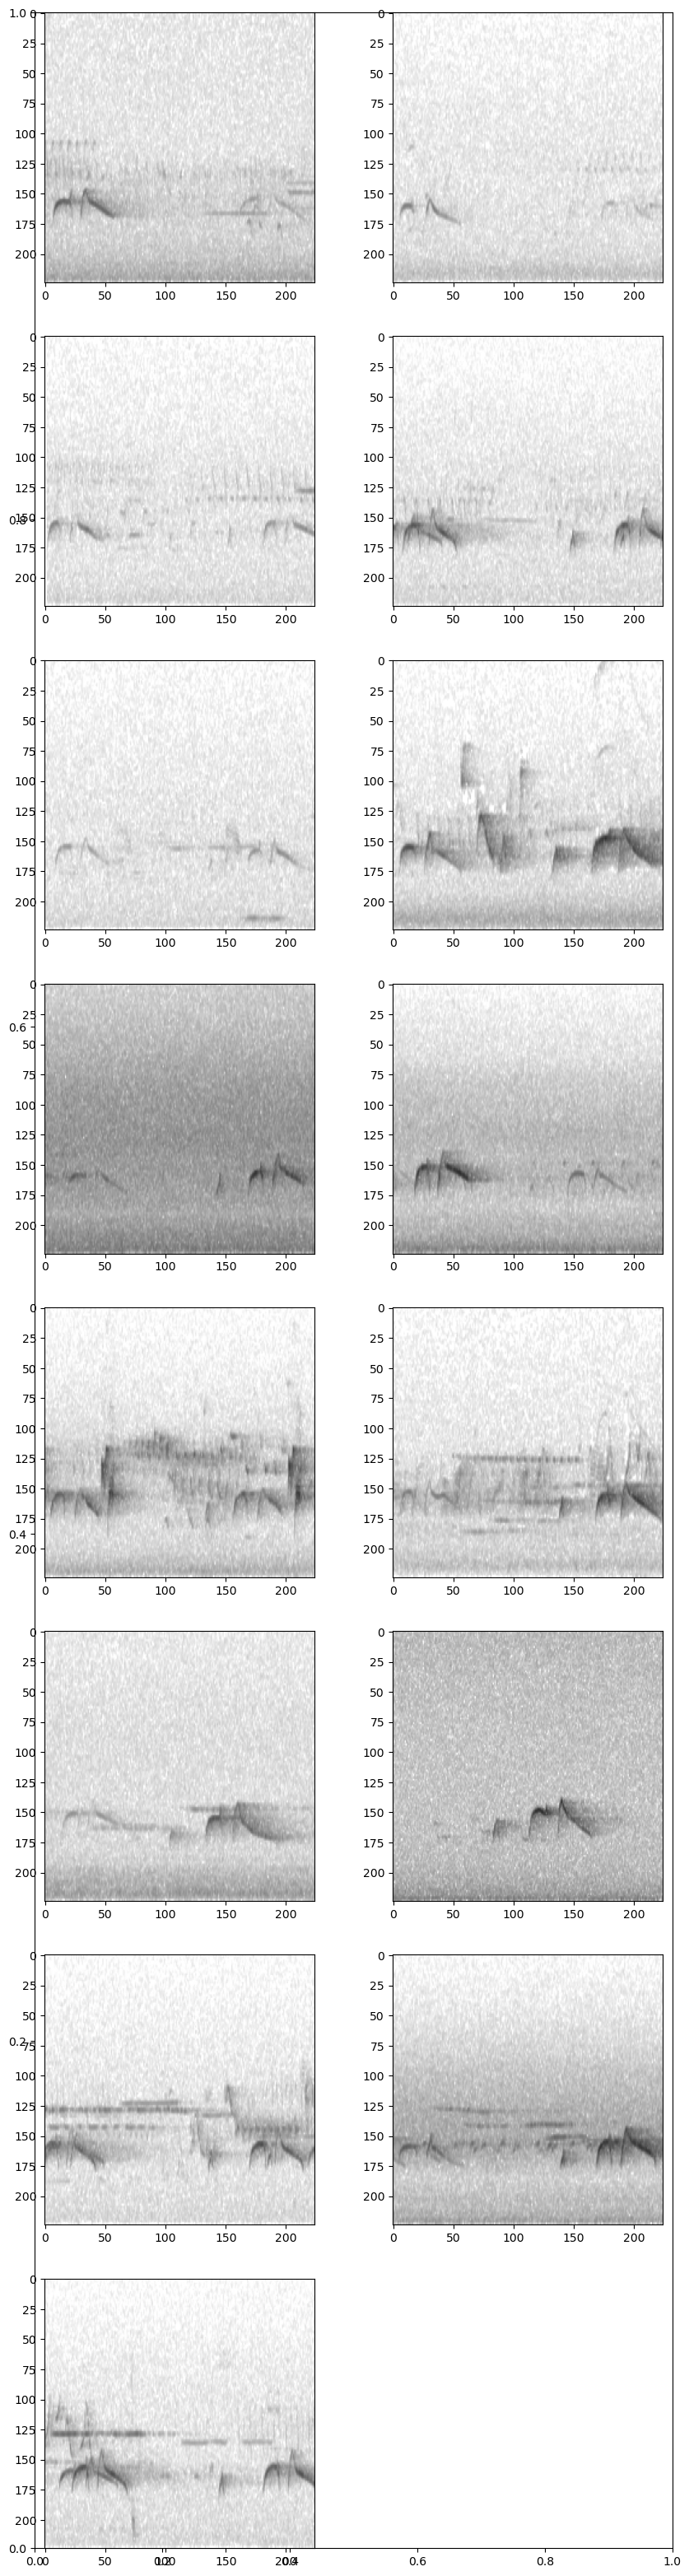

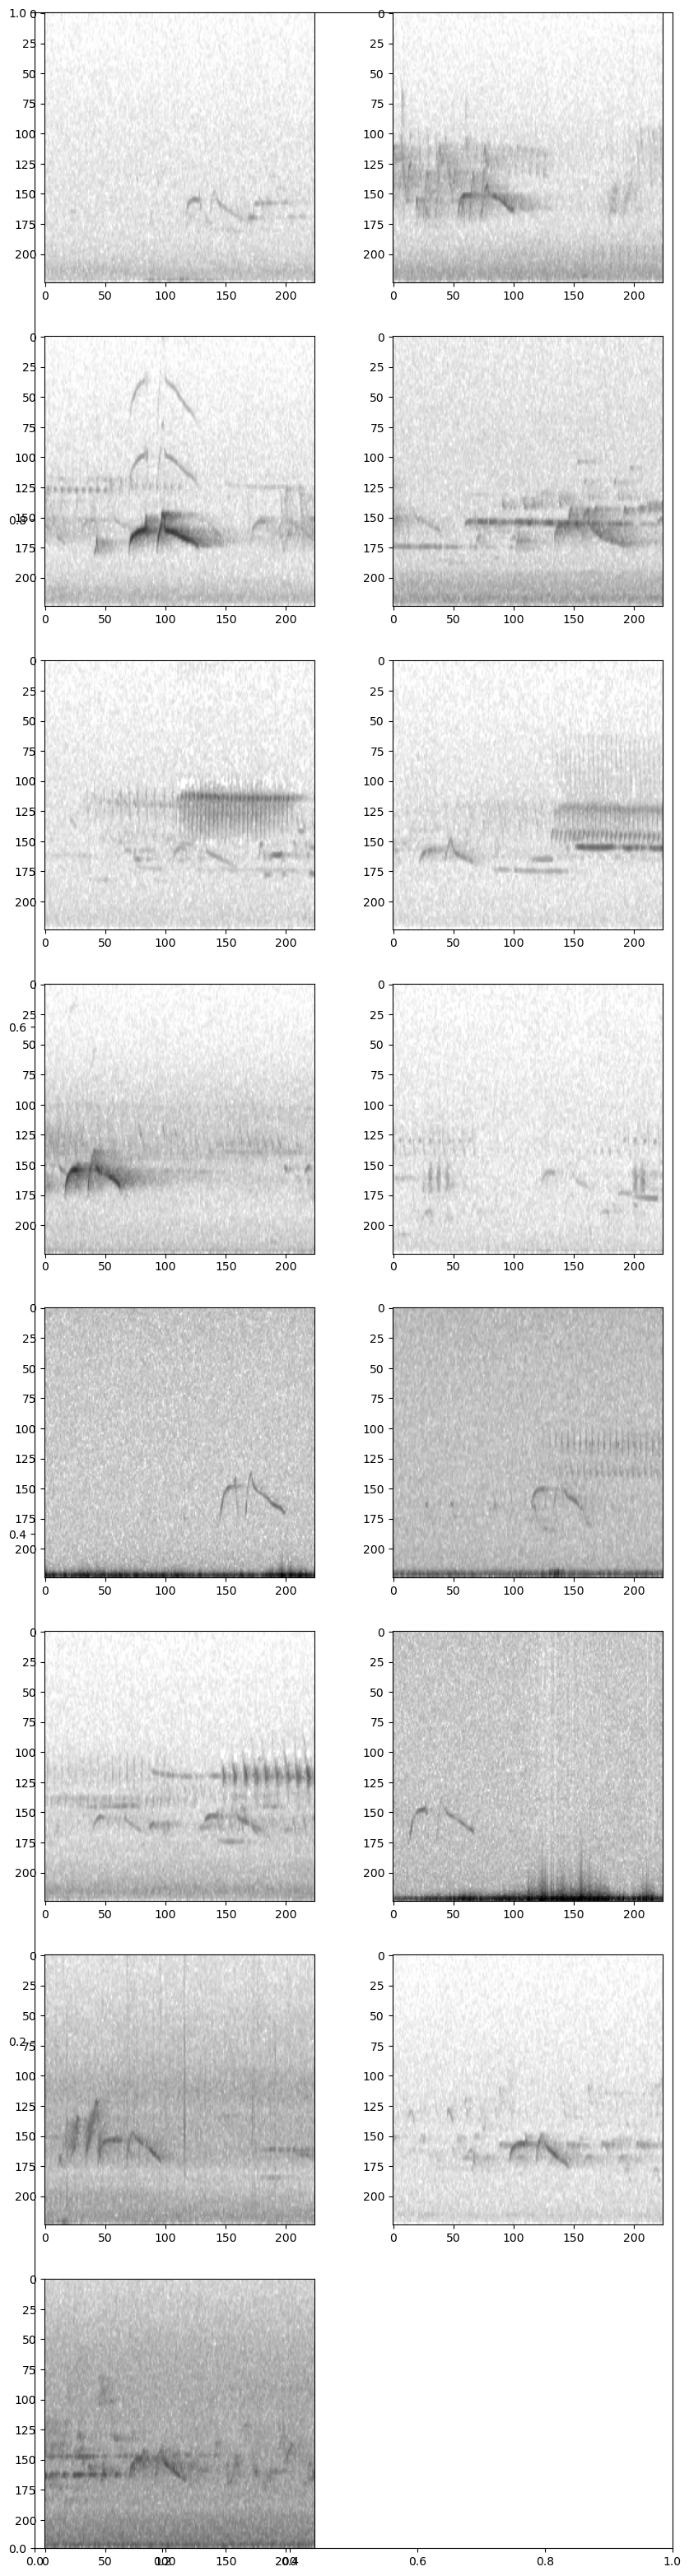

In [54]:
worst_focal = top_focal_unique.sort_values("target_present", ascending=True)[:15]
best_focal = top_focal_unique.sort_values("target_present", ascending=False)[:15]

show_samples_in_df(best_focal, model)
show_samples_in_df(worst_focal, model)

In [55]:
top_focal_unique.rename(columns={"target_present": "predicted"}, inplace=True)
top_focal_unique["target_present"] = 1.0
top_focal_unique["confidence_cat"] = 0

In [58]:
top_focal_unique["loss"]  = abs(top_focal_unique["predicted"] - top_focal_unique["target_present"])

In [59]:
top_focal_unique.head()

predicted  \
file                                               start_time end_time              
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5      0.991321   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5       0.994632   
                                                   78.0       81.0       0.993721   
                                                   97.5       100.5      0.989735   
                                                   109.5      112.5      0.993440   

                                                                        target_present  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5                1.0   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5                 1.0   
                                                   78.0       81.0                 1.0   
                                                   97.5       100.5                1.0   
                                                   109.5      112.5                1.0   

                                                                        confidence_cat  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5                  0   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5                   0   
                                                   78.0       81.0                   0   
                                                   97.5       100.5                  0   
                                                   109.5      112.5                  0   

                                                                            loss  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5     0.008679  
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5      0.005368  
                                                   78.0       81.0      0.006279  
                                                   97.5       100.5     0.010265  
                                                   109.5      112.5     0.006560


# Label the test set with confidence scores


In [1832]:
verify_samples(top_focal_unique, ground_truth=1.0, loss_sorted=True, autolabel=4)

No unverified clips within chosen target class.


predicted  \
file                                               start_time end_time              
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5      0.991321   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5       0.994632   
                                                   78.0       81.0       0.993721   
                                                   97.5       100.5      0.989735   
                                                   109.5      112.5      0.993440   
...                                                                           ...   
../../data/raw/recordings/OSFL/recording-97528.mp3 265.5      268.5      0.990878   
../../data/raw/recordings/OSFL/recording-97773.mp3 25.5       28.5       0.991378   
../../data/raw/recordings/OSFL/recording-97806.mp3 78.0       81.0       0.992660   
../../data/raw/recordings/OSFL/recording-97807.mp3 276.0      279.0      0.990427   
                                                   277.5      280.5      0.989616   

                                                                        target_present  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5                1.0   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5                 1.0   
                                                   78.0       81.0                 1.0   
                                                   97.5       100.5                1.0   
                                                   109.5      112.5                1.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-97528.mp3 265.5      268.5                1.0   
../../data/raw/recordings/OSFL/recording-97773.mp3 25.5       28.5                 1.0   
../../data/raw/recordings/OSFL/recording-97806.mp3 78.0       81.0                 1.0   
../../data/raw/recordings/OSFL/recording-97807.mp3 276.0      279.0                1.0   
                                                   277.5      280.5                1.0   

                                                                        confidence_cat  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5                  3   
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5                   1   
                                                   78.0       81.0                   4   
                                                   97.5       100.5                  4   
                                                   109.5      112.5                  3   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-97528.mp3 265.5      268.5                  4   
../../data/raw/recordings/OSFL/recording-97773.mp3 25.5       28.5                   4   
../../data/raw/recordings/OSFL/recording-97806.mp3 78.0       81.0                   4   
../../data/raw/recordings/OSFL/recording-97807.mp3 276.0      279.0                  3   
                                                   277.5      280.5                  3   

                                                                            loss  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-100136... 118.5      121.5     0.008679  
../../data/raw/recordings/OSFL/recording-100138... 76.5       79.5      0.005368  
                                                   78.0       81.0      0.006279  
                                                   97.5       100.5     0.010265  
                                                   109.5      112.5     0.006560  
...                                        

# Save the validation work

In [1835]:
top_focal_unique.to_pickle(data_path / "interim" / "train_set" / "train_focal.pkl")